In [2]:
# Standard library imports
from datetime import datetime, timedelta
import itertools as it
from pathlib import Path
from zipfile import ZipFile, is_zipfile

# Related third party imports
import colorcet as cc
import holoviews as hv
import hvplot.pandas
import panel as pn
from panel import widgets as pnw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bokeh.models import FixedTicker
from IPython.display import clear_output
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    recall_score,
)
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    cross_val_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    FunctionTransformer,
    QuantileTransformer,
    PowerTransformer,
)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller, pacf
from tqdm.notebook import tqdm

clear_output()

In [71]:
# Warning settings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None
# plot settings
pn.extension(template="fast", sizing_mode="stretch_width")
pn.config.throttled = True
hv.extension("bokeh")
hvplot.extension("bokeh")
clear_output()

Initial code block which main task is to unzip the contents of the compressed file.

In [4]:
# Define the path to the zipfile
zip_path = Path("data/ultimate_challenge_3.zip")


# Check if the zipfile exists with a function
def check_zipfile(zip_path: Path) -> bool:
    """Check if the zipfile exists at the given path."""
    return zip_path.exists() and is_zipfile(zip_path)


# Create a function to create a new directory
def create_target_directory(target_dir: Path):
    """Creates a new_directory and returns it."""
    target_dir.mkdir(parents=True, exist_ok=True)
    return target_dir


def extract_zipfile(zip_path: Path, target_dir: Path):
    """Extracts the contents of zip at zip_path to target_dir."""
    with ZipFile(zip_path, "r") as zip_ref:
        # get a list of all the files in the zipfile
        for file in zip_ref.namelist():
            # if the file does not exist in the target directory, extract it
            if not (target_dir / file).exists():
                zip_ref.extract(file, target_dir)
        print(f"Extracted {zip_path} to {target_dir}")


# use the functions to extract the zipfile
if check_zipfile(zip_path):
    target_dir = zip_path.parent / zip_path.stem
    create_target_directory(target_dir)
    extract_zipfile(zip_path, target_dir)

Extracted data\ultimate_challenge_3.zip to data\ultimate_challenge_3


### Part 1: Exploratory Data Analysis

The attached `logins.json` file contains (simulated) timestamps of user logins in a particular geographic location.
- Aggregate these login counts based on 15minute time intervals, and 
- visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. 

Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [5]:
# Exploratory Data Analysis
logins_path = "data/ultimate_challenge_3/ultimate_challenge/logins.json"

logins_df = pd.read_json(logins_path)
print(
    f"Shape of the dataframe: {logins_df.shape[0]} rows and {logins_df.shape[1]} columns"
)
logins_df.head(10)

Shape of the dataframe: 93142 rows and 1 columns


login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21
5 1970-01-01 20:21:41
6 1970-01-01 20:12:16
7 1970-01-01 20:35:47
8 1970-01-01 20:35:38
9 1970-01-01 20:47:52

In [6]:
logins_df.describe()

login_time
count                          93142
mean   1970-02-26 19:09:39.779648278
min              1970-01-01 20:12:16
25%       1970-02-04 10:37:19.750000
50%       1970-03-01 06:33:05.500000
75%       1970-03-22 04:01:10.750000
max              1970-04-13 18:57:38

In [7]:
logins_copy = logins_df.copy()

Series not in perfect chronological order but is generally it is . 

In [8]:
# settings so that scroll is not active for the plot
active_opts = dict(active_tools=["box_zoom"])

logins_copy = logins_copy.reset_index().rename(
    columns={"index": "original_index"})

logins_copy["is_duplicate"] = logins_copy.duplicated(
    subset="login_time", keep=False)

logins_copy["hour"] = logins_copy["login_time"].dt.hour
logins_copy["week"] = logins_copy["login_time"].dt.isocalendar().week

# get the duplicate login times
duplicated_logins = logins_copy.loc[logins_copy["is_duplicate"] == True]

In [9]:
# create a hook for the xaxis lables to be [0, 6, 12, 18]
def hours_hook(plot, element):
    plot.state.xaxis.ticker = FixedTicker(ticks=list(range(0, 24, 6)))

In [10]:
def create_scatter_hist(df, x, y, xbins=16, ybins=24):
    """Create a scatter plot and two histograms for the given DataFrame and columns."""
    # opts to prevent the scroll from being active
    active_options = dict(active_tools=["box_zoom"])
    # Create a scatter plot
    scatter = df.hvplot.scatter(
        x=x, y=y, width=800, height=400, xlabel="", ylabel="", alpha=0.5
    ).opts(**active_options)

    # Create a histogram of the 'hour' column
    yhist = df.hvplot.hist(y=y, width=200, height=400, bins=ybins).opts(
        **active_options
    )

    # Create a histogram of the 'login_time' column
    xhist = df.hvplot.hist(y=x, width=800, height=200, xlabel="", bins=xbins).opts(
        **active_options
    )

    # Combine the plots
    plot = scatter << yhist << xhist

    return plot

In [11]:
plot1 = create_scatter_hist(duplicated_logins, "login_time", "hour").opts(
    title="Duplicated Logins Distribution"
)
plot1

:AdjointLayout
   :Scatter   [login_time]   (hour)
   :Histogram   [hour]   (hour_count)
   :Histogram   [login_time]   (login_time_count)

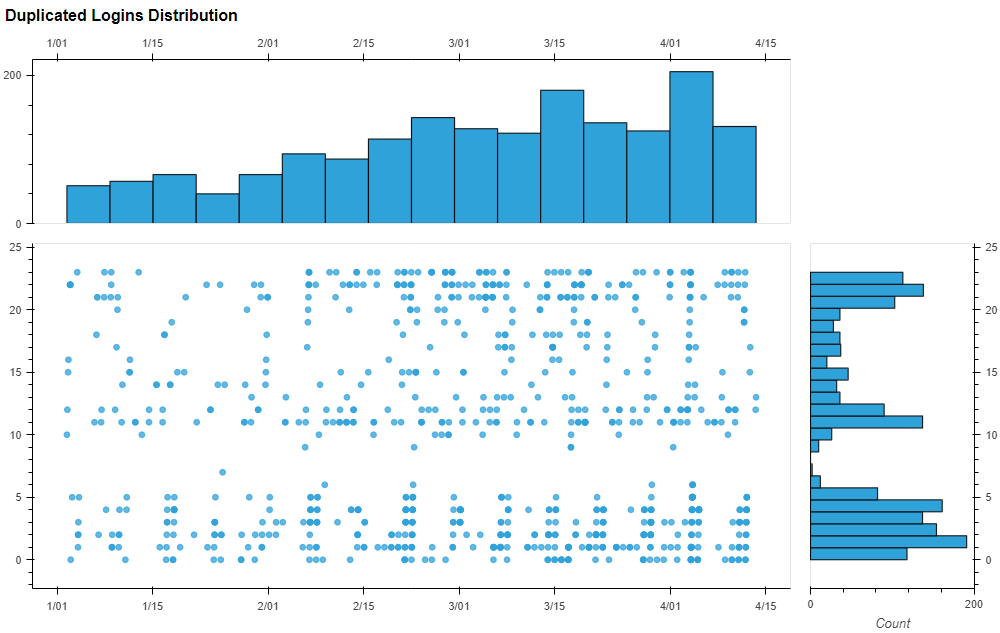

In [12]:
plot2 = create_scatter_hist(logins_copy, "login_time", "hour").opts(
    title="Logins Distribution"
)
plot2

:AdjointLayout
   :Scatter   [login_time]   (hour)
   :Histogram   [hour]   (hour_count)
   :Histogram   [login_time]   (login_time_count)

 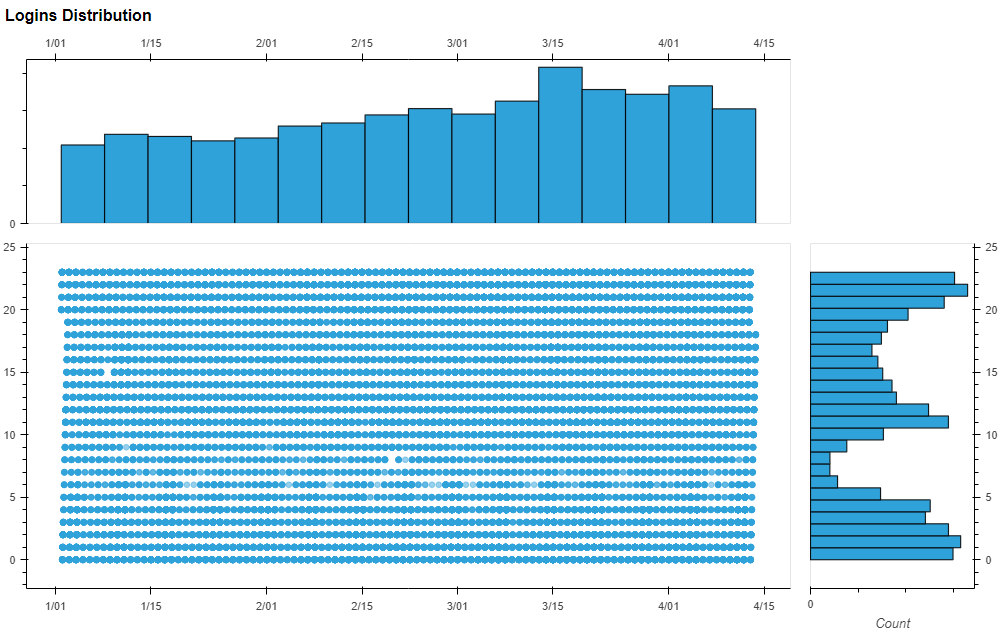

There are 2 hous in the dataset where no logins happened. 
- 1970-01-08 at 3pm
- 1970-02-19 as 8pm.

There is a general trend upwards for the number of logins each week.

In [13]:
# Aggregate the login on 15 minutes interval

logins_15m_count = (
    logins_copy[["login_time", "original_index"]]
    .set_index("login_time")
    .resample("15min")
    .count()
    .rename(columns={"original_index": "logins_15m_count"})
)
# Confirm with the sum of the logins
print(f"Should be 93142\n{logins_15m_count.sum()=}")
display(logins_15m_count.head())
# Do a plot of the logcounts at 15 minutes interval
plot3 = logins_15m_count.hvplot.hist(
    height=400,
    width=800,
    title="Logins Count every 15 minutes",
    ylabel="",
).opts(active_tools=["box_zoom"])

plot3

Should be 93142
logins_15m_count.sum()=logins_15m_count    93142
dtype: int64


logins_15m_count
login_time                           
1970-01-01 20:00:00                 2
1970-01-01 20:15:00                 6
1970-01-01 20:30:00                 9
1970-01-01 20:45:00                 7
1970-01-01 21:00:00                 1

:Histogram   [logins_15m_count]   (logins_15m_count_count)

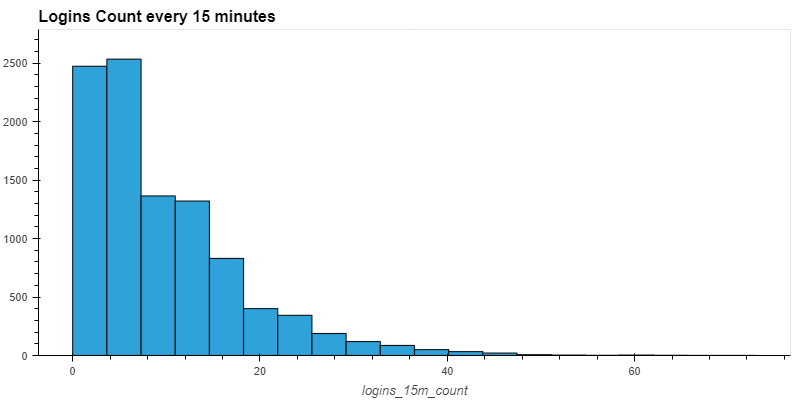

The frequency for the number of logins every 15 mins is right-skewed, with the mean greater then the median.

In [14]:
# Create the KDE plot
kde_15m = logins_15m_count["logins_15m_count"].hvplot(
    kind="kde",
    xlim=(0, None),
    ylabel="",
    xlabel="Logins Count at 15 min Intervals",
    title="Logins Kernel Density Plot",
)
mean_value = logins_15m_count["logins_15m_count"].mean()
median_value = logins_15m_count["logins_15m_count"].median()

# Create the vertical lines
mean_line = hv.VLine(mean_value).opts(color="red")
median_line = hv.VLine(median_value).opts(color="green")

# Create the legend
mean_legend = hv.Text(mean_value, 0, " Mean", halign="left", valign="bottom").opts(
    color="red"
)
median_legend = hv.Text(
    median_value, 0, " Median", halign="right", valign="bottom"
).opts(color="green")

# Combine everything
plot4 = (kde_15m * mean_line * median_line * mean_legend * median_legend).opts(
    active_tools=["box_zoom"]
)

# plot4

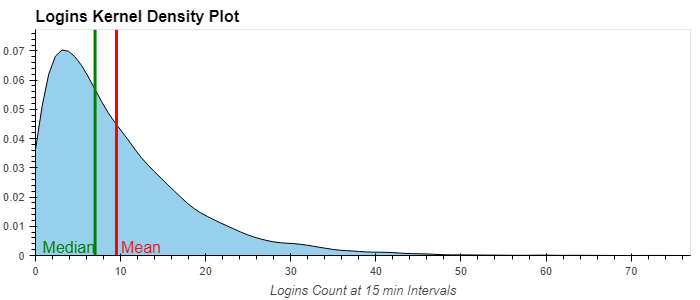

The demand appears seasonal with a weekly frequency. The highest number of logins occurs on the weekends (both Saturday and Sunday).

In [15]:
login_daily = (
    logins_copy[["login_time", "original_index"]]
    .set_index("login_time")
    .resample("D")
    .count()
    .rename(columns={"original_index": "logins_daily_count"})
)
login_daily["is_weekend"] = "blue"
login_daily.loc[login_daily.index.dayofweek >= 5, "is_weekend"] = "red"

display(login_daily.head(3))


plot5 = login_daily.hvplot() * login_daily.hvplot.scatter(
    title="Daily Logins with Weekends Highlighted",
    color=login_daily["is_weekend"],
).opts(active_tools=["box_zoom"])

# plot5

logins_daily_count is_weekend
login_time                               
1970-01-01                 112       blue
1970-01-02                 681       blue
1970-01-03                 793        red

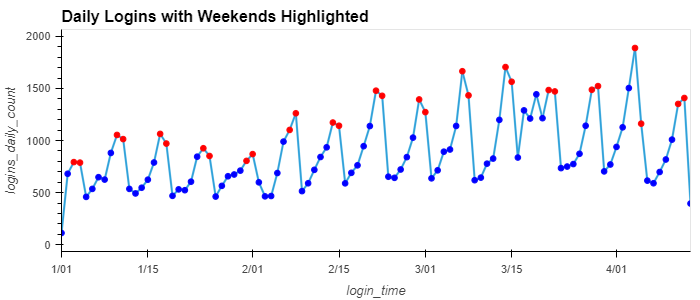

In [16]:
logins_15m_count["week"] = logins_15m_count.index.isocalendar().week
logins_15m_count["weekday"] = logins_15m_count.index.weekday
logins_15m_count["hour"] = logins_15m_count.index.hour
logins_15m_count["day"] = logins_15m_count.index.day

In [17]:
weekday_dict = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}
logins_15m_count["day_of_week"] = logins_15m_count["weekday"].map(weekday_dict)
weekday_counts = (
    logins_15m_count.groupby(["weekday"], observed=True)["logins_15m_count"]
    .sum()
    .reset_index()
)
weekday_counts["weekday"] = weekday_counts["weekday"].map(weekday_dict)
display(weekday_counts.head(3))
plot6 = weekday_counts.hvplot.bar(
    x="weekday",
    y="logins_15m_count",
    title="Total Logins Count by Weekday",
    ylabel="",
    xlabel="",
    height=400,
    width=800,
).opts(active_tools=["box_zoom"])
plot6

weekday  logins_15m_count
0     Monday              8823
1    Tuesday              9268
2  Wednesday             10339

:Bars   [weekday]   (logins_15m_count)

 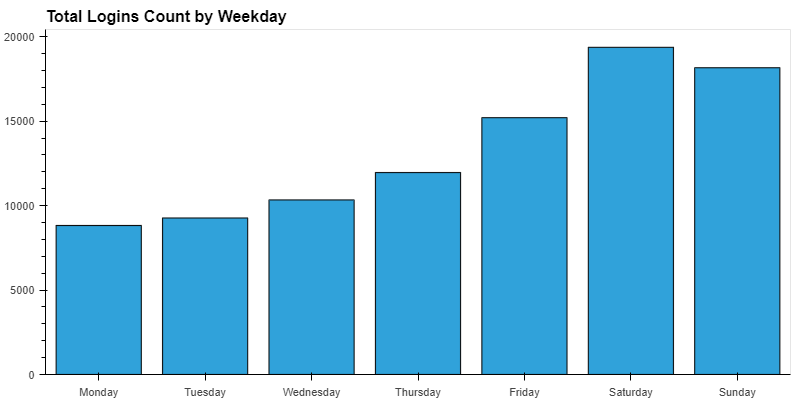

The hourly profile looks significantly different for the weekday versus the weekend. 

During the week
- there is a gentle undulation with peaks around 11am and 10pm, 
- a minimum point at 6am which is near 0 near zero.
- there is less variance during the week


On the weekends, 
- there is alternations in the number of logins
-  but between 12am and 4am, there is higher login traffic than at any other hours of the day. This is a gradual increase.
-  there is s steep dropoff after 4am.

In [19]:
# Separate weekdays and weekends
weekdays_login = logins_15m_count[logins_15m_count["weekday"] < 5]
weekend_login = logins_15m_count[logins_15m_count["weekday"] >= 5]

# Plot of the weekday days mean aggregation by the hour
weekday_avg = weekdays_login.groupby("hour")["logins_15m_count"].mean()

# Plot of the weekend days mean aggregation by the hour
weekend_avg = weekend_login.groupby("hour")["logins_15m_count"].mean()

# Plot of each day of the week faded out
daily_plots = (
    logins_15m_count.groupby(["weekday", "hour"])["logins_15m_count"]
    .mean()
    .unstack(level=0)
    .rename(columns=weekday_dict)
    .hvplot(alpha=0.2, color="gray", label="")
)

# Plot the average logins by hour for weekdays and weekends overlaid
plot7 = (
    weekday_avg.hvplot(label="Weekday")
    * weekend_avg.hvplot(label="Weekend")
    * daily_plots
).opts(
    active_tools=["box_zoom"],
    title="Average Logins by Hour of Day",
    xlabel="Hour of Day",
    hooks=[hours_hook],
)
plot7

:Overlay
   .Curve.Weekday :Curve   [hour]   (logins_15m_count)
   .Curve.Weekend :Curve   [hour]   (logins_15m_count)
   .NdOverlay.I   :NdOverlay   [weekday]
      :Curve   [hour]   (value)

 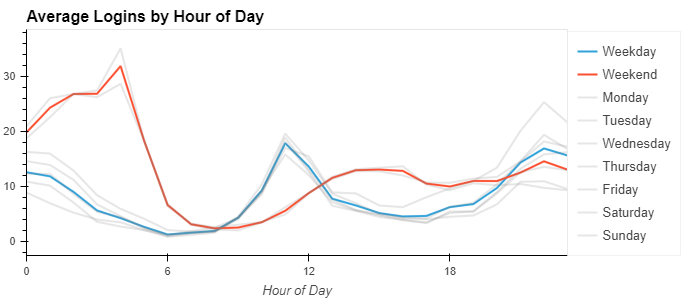

In [21]:
logins_copy["week"] = logins_copy["login_time"].dt.isocalendar().week
logins_copy["weekday"] = logins_copy["login_time"].dt.weekday
logins_copy["hour"] = logins_copy["login_time"].dt.hour
logins_copy["day"] = logins_copy["login_time"].dt.day
weekday_login = logins_copy.loc[logins_copy["weekday"] < 5]
weekend_login = logins_copy.loc[logins_copy["weekday"] >= 5]

In [22]:
plot8 = create_scatter_hist(weekday_login, "login_time", "hour").opts(
    title="Weekday Logins Distribution"
)
# plot8


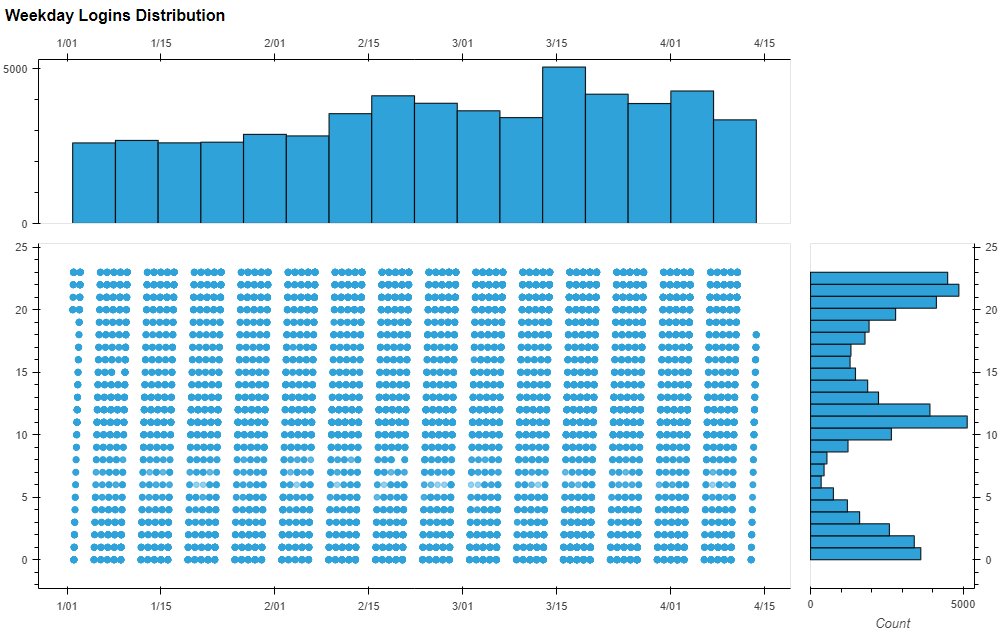

In [23]:
plot9 = create_scatter_hist(weekend_login, "login_time", "hour").opts(
    title="Weekend Logins Distribution"
)
# plot9

 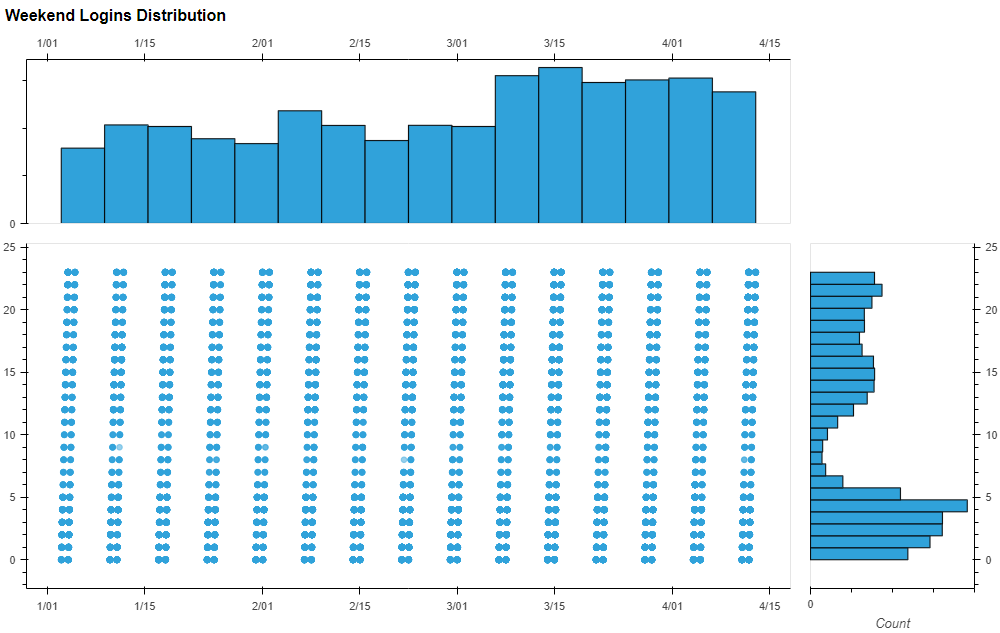

In [24]:
day_of_week_hour_long = logins_15m_count.groupby(
    ["weekday", "hour"], as_index=False, observed=True
)["logins_15m_count"].sum()
day_of_week_hour_long["weekday"] = day_of_week_hour_long["weekday"].map(
    weekday_dict)
day_of_week_hour_long["weekday"] = pd.Categorical(
    day_of_week_hour_long["weekday"], categories=weekday_dict.values(), ordered=True
)
display(day_of_week_hour_long.head(3))
plot10 = day_of_week_hour_long.hvplot.heatmap(
    x="hour",
    y="weekday",
    C="logins_15m_count",
    title="Logins Count by Hour and Weekday",
    xlabel="Hour of Day",
    ylabel="",
    height=400,
    width=800,
    line_width=2,
).opts(
    active_tools=["box_zoom"],
    color_levels=5,
    hooks=[hours_hook],
)
# plot10

weekday  hour  logins_15m_count
0  Monday     0               531
1  Monday     1               414
2  Monday     2               312

 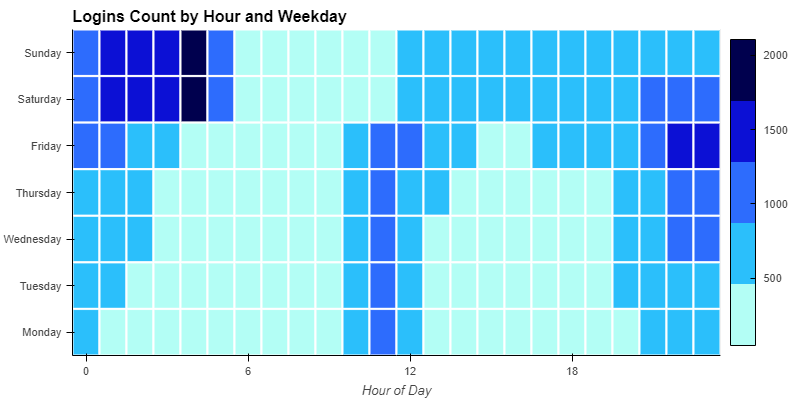

- The least activity happens between 6am and 10am, no matter the day.
- There is some significant activity that occurs between 10am and 12pm on weekdays, but this pattern does not hold for the weekends. 
- The activity peaks at 4am on both Saturday and Sunday. 

In [25]:
def part_of_day(hour):
    if hour < 6:
        return "Night"
    elif hour < 12:
        return "Morning"
    elif hour < 18:
        return "Afternoon"
    else:
        return "Evening"


day_of_week_hour_long["part_of_day"] = day_of_week_hour_long["hour"].apply(
    part_of_day)
weekday_part_of_day_group = day_of_week_hour_long.groupby(
    ["weekday", "part_of_day"], as_index=False
)["logins_15m_count"].sum()

# set the order of the part_of_day categories
weekday_part_of_day_group["part_of_day"] = pd.Categorical(
    weekday_part_of_day_group["part_of_day"],
    categories=["Morning", "Afternoon", "Evening", "Night"],
    ordered=True,
)
weekday_part_of_day_pivot = weekday_part_of_day_group.pivot(
    index="weekday", columns="part_of_day", values="logins_15m_count"
)
display(weekday_part_of_day_pivot.head(3))

plot11 = weekday_part_of_day_pivot.hvplot.heatmap(
    C="logins_15m_count",
    title="Logins Count by Part of Day and Weekday",
    xlabel="Part of Day",
    ylabel="",
    height=400,
    width=600,
    line_width=2,
).opts(active_tools=["box_zoom"], color_levels=7)
# plot11

part_of_day  Morning  Afternoon  Evening  Night
weekday                                        
Monday          2085       2265     2653   1820
Tuesday         1934       2029     3278   2027
Wednesday       2036       2144     3625   2534

 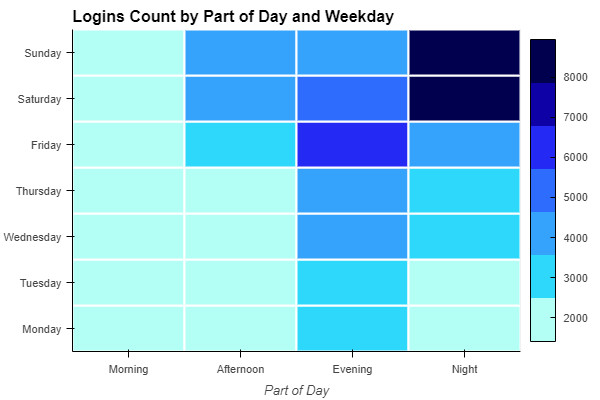

Activity increases for the nights as the week progresses  starting from Monday, with the most activity happening on Saturday and Sunday nights.

There is the lowest activity in the mornings, no matter the day of the week.

In [26]:
# draw a scatterplot of weekday_part_of_day_group with the weekdays(M-F) one color and
# the weekends another color
weekday_part_of_day_group["is_weekend"] = weekday_part_of_day_group["weekday"].isin(
    ["Saturday", "Sunday"]
)
display(weekday_part_of_day_group.head(3))

plot12 = (
    weekday_part_of_day_group.sort_values(by="part_of_day")
    .hvplot.scatter(
        x="part_of_day",
        y="logins_15m_count",
        c="is_weekend",
        cmap=["blue", "red"],
        title="Logins Count by Part of Day and Weekday",
        xlabel="",
        ylabel="",
        height=400,
        width=600,
        hover_cols=["weekday"],
        alpha=0.6,
        size=100,
    )
    .opts(active_tools=["box_zoom"], legend_labels={False: "Weekday", True: "Weekend"})
)
# plot12

weekday part_of_day  logins_15m_count  is_weekend
0  Monday   Afternoon              2265       False
1  Monday     Evening              2653       False
2  Monday     Morning              2085       False

 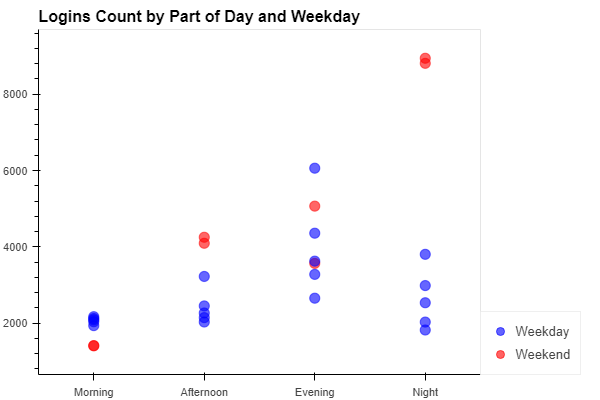

Although the weekend days have higher activity than the weekdays for the afternoons and for the nights parts of day, they have the lowest activities for the morning than any other days

Seasonal decomposition of the time series into 
- trend, 
- seasonality 
- residuals

In [27]:
decom_opts = dict(
    height=200,
    active_tools=["box_zoom"],
    xaxis="bare",
    show_grid=True,
)

# Decompose time series into trend, seasonality, and noise
decomposition = seasonal_decompose(
    logins_15m_count["logins_15m_count"], period=96)

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot components
original_series = logins_15m_count["logins_15m_count"].hvplot().opts(
    **decom_opts)
trend_series = trend.hvplot().opts(**decom_opts)
seasonal_series = seasonal.hvplot().opts(**decom_opts)
residual_series = residual.hvplot().opts(
    height=200, active_tools=["box_zoom"], show_grid=True
)

# Combine plots in a single column layout
decomposition_layout = (
    (original_series + trend_series + seasonal_series + residual_series)
    .opts(shared_axes=True)
    .cols(1)
)

# Display layout
plot13 = decomposition_layout
# plot13

 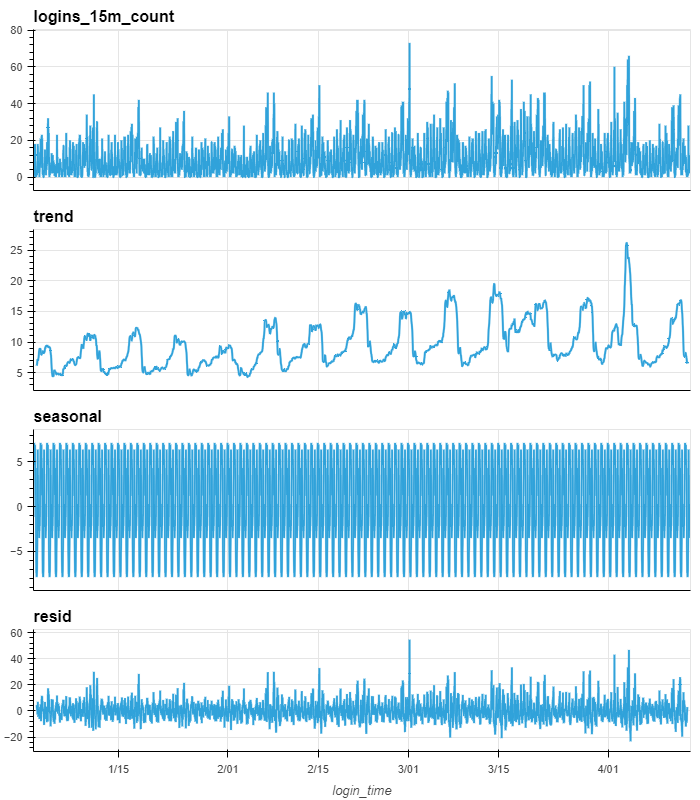

In [28]:
# Calculate the autocorrelation and partial autocorrelation values
acf_values = acf(logins_15m_count["logins_15m_count"], nlags=96)
pacf_values = pacf(logins_15m_count["logins_15m_count"], nlags=96)

# Create DataFrames for the autocorrelation and partial autocorrelation values
acf_df = pd.DataFrame({"lag": range(len(acf_values)),
                      "autocorrelation": acf_values})
pacf_df = pd.DataFrame(
    {"lag": range(len(pacf_values)), "partial_autocorrelation": pacf_values}
)

# Plot the autocorrelation and partial autocorrelation values with a hover tool
acf_plot = acf_df.hvplot.scatter(
    "lag", "autocorrelation", grid=True, hover_cols="all"
).opts(active_tools=["box_zoom"], title="Autocorrelation of Login Counts", ylabel="")
pacf_plot = pacf_df.hvplot.scatter(
    "lag", "partial_autocorrelation", grid=True, hover_cols="all"
).opts(
    active_tools=["box_zoom"],
    title="Partial Autocorrelation of Login Counts",
    ylabel="",
)

# Add a zero line to the plots
x_zero_line = hv.HLine(0).opts(color="black", line_width=1)
acf_plot *= x_zero_line
pacf_plot *= x_zero_line

# Display the plots
plot14 = hv.Layout(acf_plot + pacf_plot).cols(1)
# plot14

 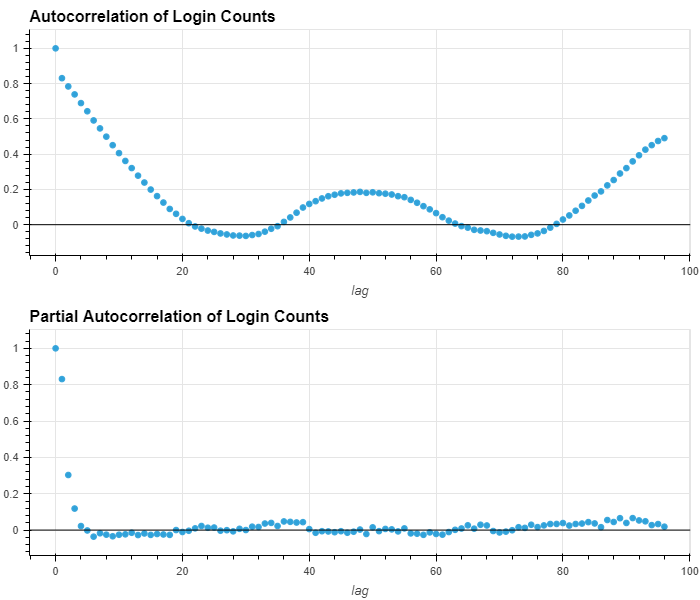

In [29]:
results = adfuller(logins_15m_count["logins_15m_count"])
print(f"ADF Statistic: {results[0]:.3f}")
print(f"p-value: {results[1]:.3f}")
if results[1] < 0.05:
    print("The time series is stationary")
else:
    print("The time series is not stationary")

for key, value in results[4].items():
    print("Critical Values:")
    print(f"{key}, {value:.3f}")

ADF Statistic: -10.338
p-value: 0.000
The time series is stationary
Critical Values:
1%, -3.431
Critical Values:
5%, -2.862
Critical Values:
10%, -2.567


### Part 2: Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.</br>
1. *What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?* </br>
**Answer**: </br>
The key measure of success would be the increase in the number of driver partners who cross the bridge (cross-city trip). This is because the goal of the experiment is to encourage driver partners to be available in both cities, and the increase in number of drivers who cross the bridge would be a direct measure of success. 

This is a good metric because it is 
- Specific: directly measures the behavior we want to influence
- Measureable: Can be tracked and quantified 
- Actionable: if we see that there is an increase in cross-city trips suggesting that the reimbursement is effective this can easily be continued or expanded
- Relevant: directly relates to the goal of the experiment

1. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success.

Please provide details on:
- a. *how you will implement the experiment*</br>
**Answer**: </br>
The experiment would be implemented by randomly selecting a group of driver partners from the entire pool off drivers to monitor. The sample should be random as to try to be representative of the population. This group can then be split into two equal groups. One group, the experimental group would be reimbursed for all tolls cost in a hassle free manner. The second group, the control group would continue to operate as usual without any changes. We can then measure and compare the cross-city trips made between both groups.

The experiment would be run for a period of 3 month period (12 months ideally), to avoid any influence of seasonal changes.</br>
- b. *what statistical test(s) you will conduct to verify the significance of the observation*</br>
**Answer**: </br>
*The statistical test that would be conducted to verify the significance of the observation would be a t-test. We would use the T test to compare the means of the two groups and determine if there is a significant difference.* </br>


- c. *how you would interpret the results and provide recommendations to the city operations team along with any caveats.*</br>
**Answer**: </br>
The results would help us understand whether reimbursing all toll costs had a significant effect on the number of cross-city trips. If the P-value is below a certain threshold (e.g. 0.05), we could conclude that the toll reimbursement is effective, and reject the null hypothesis. 

Some caveats:
- correlation does not imply causation. 
- other factors could be influencing the results and the experiment will not be able to prove that the toll reimbursement is the sole and primary cause of any increase in cross-city trips

### Part 3: Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).

In [30]:
ultimate_data_path = (
    "data/ultimate_challenge_3/ultimate_challenge/ultimate_data_challenge.json"
)
ultimate_data = pd.read_json(ultimate_data_path)
# Show dataframe info
ultimate_data.info()

# show dataframe statistics
ultimate_data.describe(include="all").T.sort_values("unique").infer_objects(
    copy=False
).fillna("")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


count unique         top     freq       mean  \
phone                   49604.0    2.0      iPhone  34582.0              
ultimate_black_user     50000.0    2.0       False  31146.0              
city                    50000.0    3.0  Winterfell  23336.0              
signup_date             50000.0   31.0  2014-01-18   2948.0              
last_trip_date          50000.0  182.0  2014-06-29   2036.0              
trips_in_first_30_days  50000.0                                 2.2782   
avg_rating_of_driver    41878.0                               4.601559   
avg_surge               50000.0                               1.074764   
surge_pct               50000.0                               8.849536   
weekday_pct             50000.0                              60.926084   
avg_dist                50000.0                               5.796827   
avg_rating_by_driver    49799.0                               4.778158   

                              std  min   25%   50%    75%     max  
phone                                                              
ultimate_black_user                                                
city                                                               
signup_date                                                        
last_trip_date                                                     
trips_in_first_30_days   3.792684  0.0   0.0   1.0    3.0   125.0  
avg_rating_of_driver     0.617338  1.0   4.3   4.9    5.0     5.0  
avg_surge                0.222336  1.0   1.0   1.0   1.05     8.0  
surge_pct               19.958811  0.0   0.0   0.0    8.6   100.0  
weekday_pct             37.081503  0.0  33.3  66.7  100.0   100.0  
avg_dist                 5.707357  0.0  2.42  3.88   6.94  160.96  
avg_rating_by_driver     0.446652  1.0   4.7   5.0    5.0     5.0

In [31]:
ultimate_df = ultimate_data.copy()
display(ultimate_df.sample(3))
# display sample of the dataframe
ultimate_df.sample().T

city  trips_in_first_30_days signup_date  \
37176      Winterfell                       0  2014-01-01   
34083      Winterfell                       0  2014-01-15   
39189  King's Landing                       1  2014-01-11   

       avg_rating_of_driver  avg_surge last_trip_date    phone  surge_pct  \
37176                   NaN       1.00     2014-06-15  Android        0.0   
34083                   5.0       1.83     2014-02-25   iPhone       33.3   
39189                   5.0       1.00     2014-01-12   iPhone        0.0   

       ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver  
37176                False          0.0      4.26                   5.0  
34083                 True        100.0      1.62                   4.7  
39189                False          0.0     13.91                   5.0

45720
city                    Winterfell
trips_in_first_30_days           1
signup_date             2014-01-07
avg_rating_of_driver           4.5
avg_surge                      1.0
last_trip_date          2014-06-12
phone                       iPhone
surge_pct                      0.0
ultimate_black_user          False
weekday_pct                   77.8
avg_dist                      3.05
avg_rating_by_driver           4.8

In [32]:
ultimate_df["is_black_user"] = ultimate_df["ultimate_black_user"].map(
    {True: "early_black", False: "regular"}
)
ultimate_df = ultimate_df.drop(columns=["ultimate_black_user"])

In [33]:
# Convert dates to datetime format
ultimate_df["signup_date"] = pd.to_datetime(
    ultimate_df["signup_date"], format="%Y-%m-%d"
)
ultimate_df["last_trip_date"] = pd.to_datetime(
    ultimate_df["last_trip_date"], format="%Y-%m-%d"
)

print(
    f"Signup Date range :{ultimate_df['signup_date'].min()} - {ultimate_df['signup_date'].max()}"
)
print(
    f"Last Trip range :{ultimate_df['last_trip_date'].min()} - {ultimate_df['last_trip_date'].max()}"
)

Signup Date range :2014-01-01 00:00:00 - 2014-01-31 00:00:00
Last Trip range :2014-01-01 00:00:00 - 2014-07-01 00:00:00


Identify the active users which will become the target variable for prediction.

In [34]:
# Identify the last date in the dataset
latest_date = max(ultimate_df["last_trip_date"])
cutoff_date = latest_date - timedelta(days=30)

# Identify active users
ultimate_df["active"] = ultimate_df["last_trip_date"].apply(
    lambda date: date >= cutoff_date
)

# Calculate the retention rate
retention_rate = (ultimate_df["active"].sum() / len(ultimate_df)) * 100
print(f"Fraction of active users: {retention_rate:.1f}%")

Fraction of active users: 37.6%


In [35]:
ultimate_df["active"] = ultimate_df["active"].astype(int)

In [36]:
signup_last_trip_scatter = (
    ultimate_df.sort_values(by="signup_date")
    .hvplot.scatter(
        x="last_trip_date",
        y="signup_date",
        by="active",
        cmap=["gray", "green"],
        title="Last Trip Date vs Signup Date",
        size=5,
        marker="s",
        height=600,
        width=800,
        legend=False,
    )
    .opts(active_tools=["box_zoom"])
)
# add text to the plot to indicate the cutoff date, anf the active users
active_text = hv.Text(
    cutoff_date,
    ultimate_df["signup_date"].max(),
    "Active Users",
    halign="left",
    valign="bottom",
).opts(color="red")

cutoff_line = hv.VLine(cutoff_date).opts(
    color="gray", line_dash="dashed", active_tools=["box_zoom"]
)
signup_last_trip_scatter * cutoff_line * active_text

:Overlay
   .NdOverlay.I :NdOverlay   [active]
      :Scatter   [last_trip_date]   (signup_date)
   .VLine.I     :VLine   [x,y]
   .Text.I      :Text   [x,y]

From the plot above we can see which riders are in the cutoff period for being considered active.

In [37]:
# Create a widget to select the date
cutoff_date_slider = pnw.DateSlider(
    name="Cutoff Date",
    start=datetime(2014, 2, 1),
    end=datetime(2014, 6, 1),
    value=datetime(2014, 1, 1) + timedelta(days=31),
)


# define a callback to show the histogram of the last trip date from date selected to 30 days prior
@pn.depends(cutoff_date_slider.param.value)
def last_trip_date_histogram(date_mark):
    """Creates two histograms side by side of the signup date distribution.
    As the cut off date slider is moved, the nonactive customers are moved to the right histogram
    leaving the active customers in the left histogram."""
    # Define the date to separate the active and nonactive customers
    slider_date = pd.to_datetime(date_mark)
    # get the distribution of both the active and nonactive customers
    initial_distro = (
        ultimate_df.loc[(ultimate_df["last_trip_date"]
                         > slider_date), "signup_date"]
        .hvplot.hist(
            title="Signup Date Distribution",
            xlabel="Signup Date",
            ylabel="Count",
            bins=31,
        )
        .opts(active_tools=["box_zoom"])
    )

    final_distro = (
        ultimate_df.loc[(ultimate_df["last_trip_date"]
                         < slider_date), "signup_date"]
        .hvplot.hist(
            title="Lost Customers Distribution",
            xlabel="Signup Date",
            ylabel="Count",
            bins=31,
        )
        .opts(active_tools=["box_zoom"])
    )
    return initial_distro + final_distro


# Create a panel layout
hist_panel = pn.pane.HoloViews(
    last_trip_date_histogram, sizing_mode="stretch_width")
pn.Column("### Signup Date Distribution", cutoff_date_slider, hist_panel)

BokehModel(combine_events=True, render_bundle={'docs_json': {'537268b2-e579-4edb-9db9-b799a0fa14e5': {'version…

The histograms above shows how the distribution of the active and nonactive users changes as the cutoff date is changed. Notice how the shape of the profile is mostly constant, saying that we lose users at about the same rate proportionally.,and we don't lose users who signed up on any one day faster than the other.

In [38]:
initial_count = (
    ultimate_df["signup_date"]
    .value_counts()
    .sort_index()
    .reset_index(name="initial_signup_count")
)

active_users_count = (
    ultimate_df.loc[ultimate_df["active"] == 1, "signup_date"]
    .value_counts()
    .sort_index()
    .reset_index(name="active_count")
)
non_active_users_count = (
    ultimate_df.loc[ultimate_df["active"] == 0, "signup_date"]
    .value_counts()
    .sort_index()
    .reset_index(name="non_active_count")
)
# the active users distribution profile correlates with the initial signup date distribution
start_end_counts = (
    initial_count.merge(active_users_count)
    .merge(non_active_users_count)
    .set_index("signup_date")
)

start_end_counts.hvplot.step(
    title="Signup Date Count Profile of Active and NonActive Users (cutoff date 2014-06-01)",
    xlabel="",
).opts(
    **active_opts,
    legend_position="top_left",
    legend_labels={
        "initial_signup_count": "Initial Signups",
        "active_count": "Active Users",
        "non_active_count": "NonActive Users",
    },
    legend_opts={"title": ""}
)

:NdOverlay   [Variable]
   :Curve   [signup_date]   (value)

Here we define some functions which will make plotting to visualize the distributions easier to be able to compare the distributions of the active and inactive users.

In [39]:
def plot_cat_active_stacked_bars(df, list_of_cat_cols, target_col="active", stacked=True):
    """Create a bar plot for each categorical column showing the proportion of active users."""

    plot_opts = dict(height=300, width=400, active_tools=["box_zoom"])
    cat_plots = []
    for column in list_of_cat_cols:
        proportions = (
            df.groupby(column)[target_col].value_counts(
                normalize=True).unstack()
        )
        plot = proportions.hvplot.barh(
            title=(
                f"{column}".replace("_", " ").title()
                if "_" in column
                else column.title()
            ),
            xlabel="",
            ylabel="",
            stacked=stacked,
            cmap=["lightgray", "green"],
            legend=False,
        ).opts(**plot_opts, legend_position="top_right")
        cat_plots.append(plot)
    return hv.Layout(cat_plots).cols(3)


def plot_num_active_violins(df, list_of_num_cols, target_col="active"):
    """Create 2 violin plot for each numerical column with the active users and non active users."""

    plot_opts = dict(height=300, width=400, active_tools=["box_zoom"])
    num_plots = []
    for column in list_of_num_cols:
        plot = df.hvplot.violin(
            y=column,
            by=target_col,
            c=target_col,
            ylabel="",
            title=f"{column}".replace("_", " ").title(),
            cmap=["lightgray", "green"],
        ).opts(**plot_opts)
        num_plots.append(plot)
    return hv.Layout(num_plots).cols(3)


def plot_num_active_hist(df, list_of_num_cols, target_col="active"):
    """Creates a histogram plot of each numerical column with active and non active users
    separated by color."""
    plot_opts = dict(height=300, width=400, active_tools=["box_zoom"])

    hist_plots = [
        df[[num_col] + [target_col]]
        .hvplot.hist(
            title=f"{num_col} Distribution",
            bins=12,
            xlabel="",
            by=target_col,
            alpha=0.6,
            muted_alpha=0.02,
        )
        .opts(**plot_opts)
        for num_col in list_of_num_cols
    ]
    return hv.Layout(hist_plots)

In [40]:
# create function to clip at the 1 and 99 percentile
def clip_outer(series, lower_bound=0.01, upper_bound=0.99):
    """Clip the series at the lower and upper bound percentile."""
    lower = series.quantile(lower_bound)
    upper = series.quantile(upper_bound)
    return series.clip(lower, upper)


columns_to_clip = [
    "avg_dist",
    "avg_rating_by_driver",
    "avg_rating_of_driver",
    "avg_surge",
    "surge_pct",
    "trips_in_first_30_days",
    "weekday_pct",
]

# Apply clip_1_99 to each column
for column in columns_to_clip:
    ultimate_df[f"{column}_clipped"] = clip_outer(
        ultimate_df[column], lower_bound=0.025, upper_bound=0.975
    )

Numerical Columns

In [41]:
# Number columns
grid_opts = dict(active_tools=["box_zoom"], height=200, width=300)
num_cols = sorted(ultimate_df.select_dtypes(include=["number"]).columns)
num_cols.remove("active")

plot_num_active_hist(ultimate_df, num_cols).cols(2)

:Layout
   .NdOverlay.I    :NdOverlay   [active]
      :Histogram   [avg_dist]   (avg_dist_count)
   .NdOverlay.II   :NdOverlay   [active]
      :Histogram   [avg_dist_clipped]   (avg_dist_clipped_count)
   .NdOverlay.III  :NdOverlay   [active]
      :Histogram   [avg_rating_by_driver]   (avg_rating_by_driver_count)
   .NdOverlay.IV   :NdOverlay   [active]
      :Histogram   [avg_rating_by_driver_clipped]   (avg_rating_by_driver_clipped_count)
   .NdOverlay.V    :NdOverlay   [active]
      :Histogram   [avg_rating_of_driver]   (avg_rating_of_driver_count)
   .NdOverlay.VI   :NdOverlay   [active]
      :Histogram   [avg_rating_of_driver_clipped]   (avg_rating_of_driver_clipped_count)
   .NdOverlay.VII  :NdOverlay   [active]
      :Histogram   [avg_surge]   (avg_surge_count)
   .NdOverlay.VIII :NdOverlay   [active]
      :Histogram   [avg_surge_clipped]   (avg_surge_clipped_count)
   .NdOverlay.IX   :NdOverlay   [active]
      :Histogram   [surge_pct]   (surge_pct_count)
   .NdOverlay.X    :NdOverlay   [active]
      :Histogram   [surge_pct_clipped]   (surge_pct_clipped_count)
   .NdOverlay.XI   :NdOverlay   [active]
      :Histogram   [trips_in_first_30_days]   (trips_in_first_30_days_count)
   .NdOverlay.XII  :NdOverlay   [active]
      :Histogram   [trips_in_first_30_days_clipped]   (trips_in_first_30_days_clipped_count)
   .NdOverlay.XIII :NdOverlay   [active]
      :Histogram   [weekday_pct]   (weekday_pct_count)
   .NdOverlay.XIV  :NdOverlay   [active]
      :Histogram   [weekday_pct_clipped]   (weekday_pct_clipped_count)



We can see that by clipping the outer percentile values , we remove the outliers and allow the profile of the histograms to be more visible. This is especially true for the `avg_dist` and the `trip_in_first_30_days` columns.

In [42]:
clipped_num_cols = [num_col for num_col in num_cols if "clipped" in num_col]
# Quantile transform
q_transform = QuantileTransformer(output_distribution="normal")
ultimate_q_df = pd.DataFrame(
    q_transform.fit_transform(ultimate_df[num_cols]), columns=num_cols
)
# Add the active column to the quantile transformed dataframe
new_ultimate_q_df = pd.concat(
    [ultimate_q_df[clipped_num_cols], ultimate_df["active"]], axis=1
)

plot_num_active_hist(new_ultimate_q_df, clipped_num_cols).cols(3)

:Layout
   .NdOverlay.I   :NdOverlay   [active]
      :Histogram   [avg_dist_clipped]   (avg_dist_clipped_count)
   .NdOverlay.II  :NdOverlay   [active]
      :Histogram   [avg_rating_by_driver_clipped]   (avg_rating_by_driver_clipped_count)
   .NdOverlay.III :NdOverlay   [active]
      :Histogram   [avg_rating_of_driver_clipped]   (avg_rating_of_driver_clipped_count)
   .NdOverlay.IV  :NdOverlay   [active]
      :Histogram   [avg_surge_clipped]   (avg_surge_clipped_count)
   .NdOverlay.V   :NdOverlay   [active]
      :Histogram   [surge_pct_clipped]   (surge_pct_clipped_count)
   .NdOverlay.VI  :NdOverlay   [active]
      :Histogram   [trips_in_first_30_days_clipped]   (trips_in_first_30_days_clipped_count)
   .NdOverlay.VII :NdOverlay   [active]
      :Histogram   [weekday_pct_clipped]   (weekday_pct_clipped_count)

The quantile transform only really affects the `avg_dist` in terms of giving it a normal looking profile.

In [43]:
# check correlation between the numerical columns
correlation = ultimate_df[clipped_num_cols].corr()
mask = np.tril(np.ones_like(correlation, dtype=bool))
correlation_plot = correlation.hvplot.heatmap(
    title="Correlation Heatmap", height=400, width=800, rot=90
)

(correlation.where(~mask)).hvplot.heatmap().opts(
    color_levels=5, **active_opts, width=600, height=400, xrotation=90,
    title='Correlation of Numerical columns'
)

:HeatMap   [columns,index]   (value)

we can remove either the `surge_pct` or the `avg_surge` columns as they are highly correlated.

Date Columns

In [44]:
# Date columns - signup_date
ultimate_df["signup_dayofweek"] = ultimate_df["signup_date"].dt.dayofweek
ultimate_df["signup_week"] = ultimate_df["signup_date"].dt.isocalendar().week
ultimate_df["signup_week"] = ultimate_df["signup_week"].apply(
    lambda x: "w" + str(x))
ultimate_df["is_weekend_signup"] = ultimate_df["signup_dayofweek"].apply(
    lambda x: "yes" if x >= 5 else "no"
)
date_cols = ["signup_dayofweek", "signup_week", "is_weekend_signup"]
plot_cat_active_stacked_bars(ultimate_df, date_cols)

:Layout
   .Bars.I   :Bars   [signup_dayofweek,active]   (value)
   .Bars.II  :Bars   [signup_week,active]   (value)
   .Bars.III :Bars   [is_weekend_signup,active]   (value)

Not much variation in terms of active users and nonactive users for the `signup_date` columns.

Category columns

In [45]:
# Categorical columns bar plots
cat_cols = ultimate_df.select_dtypes(include=["object"]).columns.tolist()
cat_plots = [
    ultimate_df[cat_col]
    .value_counts()
    .hvplot.bar(title=f"{cat_col}", xlabel="")
    .opts(**grid_opts)
    for cat_col in cat_cols
]

hv.Layout(cat_plots)

:Layout
   .Bars.Count.I   :Bars   [city]   (count)
   .Bars.Count.II  :Bars   [phone]   (count)
   .Bars.Count.III :Bars   [is_black_user]   (count)
   .Bars.Count.IV  :Bars   [signup_week]   (count)
   .Bars.Count.V   :Bars   [is_weekend_signup]   (count)

In [46]:
ultimate_df["active"] = ultimate_df["active"].astype(int)

In [47]:
def rider_type(row):
    """Create a rider type based on the weekday_pct"""
    if row["weekday_pct_clipped"] == 0:
        return "one_type"
    elif row["weekday_pct_clipped"] == 100:
        return "one_type"
    else:
        return "both"


ultimate_df["rider_type"] = ultimate_df.apply(
    rider_type, axis=1)

ultimate_df["surge_type"] = ultimate_df["avg_surge"].apply(
    lambda x: "with_surge" if x > 1 else "no_surge",
)

In [48]:
cat_cols = ultimate_df.select_dtypes(
    include=["object", "category"]
).columns.to_list()

num_cols = ultimate_df.select_dtypes(
    include=["number"]).columns.tolist()
num_cols.remove("active")

In [49]:
plot_cat_active_stacked_bars(ultimate_df, cat_cols)

:Layout
   .Bars.I   :Bars   [city,active]   (value)
   .Bars.II  :Bars   [phone,active]   (value)
   .Bars.III :Bars   [is_black_user,active]   (value)
   .Bars.IV  :Bars   [signup_week,active]   (value)
   .Bars.V   :Bars   [is_weekend_signup,active]   (value)
   .Bars.VI  :Bars   [rider_type,active]   (value)
   .Bars.VII :Bars   [surge_type,active]   (value)

The `took_trip_in_first_30_days` column does not seem to have a significant effect on the `active` column. We also see that there is a higher probability of being an `active` user if the `rider_type` is `both` instead of `one_type` (`weekday` or `weekend`.).

`King's Landing` seems to have a higher probability of having `active` users than the other cities.

If the `phone` is `iPhone` then the user is more likely to be `active` than if the phone is `Android`.

Some of the early users of the Black feature are more likely to be `active` than the other users.

If there is some surge in the pricing of the user, they are also more likely to be `active`.

There seems to be little to no bearing on if the user will be `active` based on when they signed up( `weekday` or `weekend`. )

In [50]:
plot_num_active_violins(ultimate_df, num_cols)

:Layout
   .Violin.I    :Violin   [active]   (trips_in_first_30_days)
   .Violin.II   :Violin   [active]   (avg_rating_of_driver)
   .Violin.III  :Violin   [active]   (avg_surge)
   .Violin.IV   :Violin   [active]   (surge_pct)
   .Violin.V    :Violin   [active]   (weekday_pct)
   .Violin.VI   :Violin   [active]   (avg_dist)
   .Violin.VII  :Violin   [active]   (avg_rating_by_driver)
   .Violin.VIII :Violin   [active]   (avg_dist_clipped)
   .Violin.IX   :Violin   [active]   (avg_rating_by_driver_clipped)
   .Violin.X    :Violin   [active]   (avg_rating_of_driver_clipped)
   .Violin.XI   :Violin   [active]   (avg_surge_clipped)
   .Violin.XII  :Violin   [active]   (surge_pct_clipped)
   .Violin.XIII :Violin   [active]   (trips_in_first_30_days_clipped)
   .Violin.XIV  :Violin   [active]   (weekday_pct_clipped)
   .Violin.XV   :Violin   [active]   (signup_dayofweek)

The mostly look pretty similar between the `active`  and `nonactive` users. Few exceptions:
- `weekday_pct` has a noticably different shape for the active vs the the non-active users. The active users have in addition to the large proportion at 0 and 100% for `weekday_pct`, they also have a substantial portion for the values between 0 and 100% (~60%), that which the non active users lack.
- `trip_in_first_30_days` has a different shape for the active vs the non-active users.

In [51]:
# Took a trip in the first 30 days
ultimate_df["took_trips_in_first_30_days"] = ultimate_df[
    "trips_in_first_30_days"
].apply(lambda x: "yes" if x > 0 else "no")

# travel little distance
ultimate_df["avg_dist_low"] = ultimate_df["avg_dist"].apply(
    lambda x: "yes" if x == 0 else "no"
)

In [52]:
# weekday pct column has nonactive users with the extremes i.e. at the 0 and 100 values
ultimate_df["weekday_pct_sine"] = np.sin(
    ultimate_df["weekday_pct_clipped"] * np.pi / 100.0
)

ultimate_df[["weekday_pct_sine"] + ["active"]].hvplot.hist(
    by="active", title="Weekday Pct Sine"
).opts(**active_opts)

:NdOverlay   [active]
   :Histogram   [weekday_pct_sine]   (weekday_pct_sine_count)

In [53]:
# check correlation between the numerical columns
col_for_corr = clipped_num_cols + ["weekday_pct_sine"] + ["active"]
correlation = ultimate_df[col_for_corr].corr()
mask = np.tril(np.ones_like(correlation, dtype=bool))
correlation_plot = correlation.hvplot.heatmap(
    title="Correlation Heatmap", height=400, width=800, rot=90
)

(correlation.where(~mask)).hvplot.heatmap().opts(
    color_levels=5,
    **active_opts,
    width=600,
    height=400,
    xrotation=90,
    title="Correlation Heatmap of Clipped Numerical Columns",
)

:HeatMap   [columns,index]   (value)

In [54]:
target = ultimate_df["active"]
# check the correlation of the target with any other column
correlation = (
    ultimate_df[col_for_corr].corrwith(
        target).sort_values(ascending=False)
)
correlation_plot = correlation.hvplot.barh(
    title="Correlation of Active Users with Numerical Columns",
    width=800,
    height=400,
).opts(**active_opts)
correlation_plot

:Bars   [index]   (0)

In [55]:
# get the number of null values in each column
null_counts = ultimate_df.isnull().sum()
print(f"Null Values in Columns:\n{null_counts[null_counts > 0]}")
null_counts[null_counts > 0].hvplot.barh(title="Null Values in Columns").opts(
    **active_opts
)

Null Values in Columns:
avg_rating_of_driver            8122
phone                            396
avg_rating_by_driver             201
avg_rating_by_driver_clipped     201
avg_rating_of_driver_clipped    8122
dtype: int64


:Bars   [index]   (0)

Feature Engineering

We tested some combinations of features to see if they had any improvement on the model. None seem to give better performance than the original features one hot encoded for the recall score.

In [56]:
# def create function to combine 2/3 categorical variables and create interaction features
def combine_cat_features(df, cat1, cat2, cat3):
    """Create interaction features for two categorical variables."""
    new_df = df[[cat1, cat2, cat3, "active"]].copy()
    new_df[cat1] = new_df[cat1].astype(str)
    new_df[cat2] = new_df[cat2].astype(str)
    new_df[cat3] = new_df[cat3].astype(str)
    new_df[f"inter_{cat1}_{cat2}_{cat3}"] = (
        new_df[cat1] + "_" + new_df[cat2] + "_" + new_df[cat3]
    )
    return new_df[f"inter_{cat1}_{cat2}_{cat3}"]


# Create a copy of the DataFrame for creating interaction features
df_copy = ultimate_df.copy()
columns_to_cross = [
    "is_black_user",
    "rider_type",
    "surge_type",
    'city'
]
# create 4 columns: is_kings_landing, is_both_rider_type, is_with_surge, is_early_black for the interaction features
df_copy["is_kings_landing"] = df_copy["city"].apply(
    lambda x: 1 if x == "King's Landing" else 0
)
df_copy["is_both_rider_type"] = df_copy["rider_type"].apply(
    lambda x: 1 if x == "both" else 0
)
df_copy["is_with_surge"] = df_copy["surge_type"].apply(
    lambda x: 1 if x == "with_surge" else 0
)
df_copy["is_early_black"] = df_copy["is_black_user"].apply(
    lambda x: 1 if x == "early_black" else 0
)
# get the product of the 4 columns
df_copy["active_4_prod"] = df_copy["is_kings_landing"] * \
    df_copy["is_both_rider_type"] * \
    df_copy["is_with_surge"] * df_copy["is_early_black"]
# get the sum of the interactions
df_copy['active_4_sum'] = df_copy["is_kings_landing"] + \
    df_copy["is_both_rider_type"] + \
    df_copy["is_with_surge"] + df_copy["is_early_black"]
# plot the 2 new columns by active
df_copy[["active_4_prod", "active_4_sum", "active"]].hvplot.bar(
    by="active", title="Interaction Features"
).opts(**active_opts)

plot_cat_active_stacked_bars(df_copy, ["active_4_prod", "active_4_sum"], )

:Layout
   .Bars.I  :Bars   [active_4_prod,active]   (value)
   .Bars.II :Bars   [active_4_sum,active]   (value)

Model Selection

In [57]:
avg_dist_feature = ["avg_dist_clipped"]
numerical_features = ["trips_in_first_30_days_clipped", "weekday_pct_sine"]
categorical_features = ["phone"]
custom_features = ["city", "rider_type", "surge_type", "is_black_user"]


# Split the data into features and target
X = ultimate_df[
    numerical_features + avg_dist_feature + custom_features + categorical_features
]


y = ultimate_df["active"]
X.sample().T, y.sample()

(                                         32498
 trips_in_first_30_days_clipped             2.0
 weekday_pct_sine                      0.992883
 avg_dist_clipped                          2.78
 city                            King's Landing
 rider_type                                both
 surge_type                          with_surge
 is_black_user                          regular
 phone                                   iPhone,
 10156    0
 Name: active, dtype: int32)

In [58]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, city_col, rider_col, surge_col, black_col):
        self.city_col = city_col
        self.rider_col = rider_col
        self.surge_col = surge_col
        self.black_col = black_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["is_kings_landing"] = X[self.city_col].apply(
            lambda x: 1 if x == "King's Landing" else 0
        )
        X["is_both_rider_type"] = X[self.rider_col].apply(
            lambda x: 1 if x == "both" else 0
        )
        X["is_with_surge"] = X[self.surge_col].apply(
            lambda x: 1 if x == "with_surge" else 0
        )
        X["is_early_black"] = X[self.black_col].apply(
            lambda x: 1 if x == "early_black" else 0
        )
        X["active_4_sum"] = (
            X["is_kings_landing"]
            + X["is_both_rider_type"]
            + X["is_with_surge"]
            + X["is_early_black"]
        )
        return X[["active_4_sum"]]

    def get_feature_names_out(self, input_features=None):
        return ["active_4_sum"]

In [59]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=628, stratify=y
)
# avg_dist_pipe
avg_dist_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
        ("quantile", QuantileTransformer(output_distribution="normal")),
    ]
)
# create a pipeline for numerical columns
numerical_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
        ("scaler", StandardScaler()),
    ]
)

# create a pipeline for categorical columns
categorical_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent", add_indicator=True)),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)
custom_pipeline = Pipeline(
    steps=[
        ("custom", CustomTransformer(city_col="city", rider_col="rider_type",
         surge_col="surge_type", black_col="is_black_user")),
        ('scaler', StandardScaler()),
    ])
# combine the pipelines and transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_pipeline, numerical_features),
        ("avg_dist", avg_dist_pipeline, avg_dist_feature),
        ("custom", custom_pipeline, custom_features),
        ("cat", categorical_pipeline, categorical_features),
    ],
    remainder="drop",
)

In [60]:
# Models dict
models = {}
models["LogisticRegression"] = (
    LogisticRegression(
        random_state=628,
        n_jobs=-1,
        max_iter=1000,
    ),
    {
        "classifier__C": np.logspace(-3, 3, 7),
        "classifier__class_weight": ["balanced", None],
        "classifier__solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    },
)

models["LightGBM"] = (
    LGBMClassifier(
        random_state=628,
        n_jobs=-1,
        is_unbalance=True,
        num_leaves=31,
        boosting_type="gbdt",
        verbose=-1,
    ),
    {
        "classifier__learning_rate": stats.uniform(0.01, 0.5),
        "classifier__reg_alpha": stats.uniform(0.0, 0.05),
        "classifier__reg_lambda": stats.uniform(0.0, 0.05),
        "classifier__min_child_samples": stats.randint(100, 500),
        "classifier__min_data_in_leaf": stats.randint(20, 100),
    },
)

models["XGBoost"] = (
    XGBClassifier(
        random_state=628,
        scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
    ),
    {
        "classifier__n_estimators": stats.randint(100, 1000),
        "classifier__learning_rate": [0.001, 0.01, 0.1, 0.2, 0.4, 0.5],
        "classifier__max_depth": stats.randint(3, 10),
        "classifier__subsample": stats.uniform(0.6, 0.4),
        "classifier__colsample_bytree": stats.uniform(0.6, 0.4),
        "classifier__colsample_bylevel": stats.uniform(0.6, 0.4),
        "classifier__min_child_weight": stats.randint(1, 200),
    },
)
# add in a KNN model
models["KNN"] = (
    KNeighborsClassifier(n_jobs=-1),
    {
        "classifier__n_neighbors": [i for i in range(11, 31) if i % 2 != 0],
        "classifier__weights": ["uniform", "distance"],
        "classifier__p": [1, 2],
        "classifier__leaf_size": stats.randint(10, 51),
    },
)

In [61]:
# Create an empty dictionary to store the best models
best_models = {}

# Loop through each model and perform random search
for model_name, (model, param_grid) in tqdm(models.items(), desc="Model Tuning"):
    # Create a pipeline for the model
    model_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", model),
        ]
    )

    # Perform RandomizedSearchCV
    random_search = RandomizedSearchCV(
        model_pipeline,
        param_grid,
        n_iter=15,
        cv=5,
        random_state=628,
        scoring="recall",
        n_jobs=-1,
    )

    # Fit the model
    random_search.fit(X_train, y_train)

    # Store the best model
    best_models[model_name] = random_search.best_estimator_

    # Print the best parameters and ROC AUC score for each model
    print(f"\nBest Parameters for {model_name}: {random_search.best_params_}")
    # Print the mean cross-validation score for the best parameters
    best_index = random_search.best_index_
    mean_cv_score = random_search.cv_results_["mean_test_score"][best_index]
    print(f"{model_name} - Mean CV Score for Best Parameters: {mean_cv_score:.3f}")
    y_pred_proba_tuned = random_search.best_estimator_.predict_proba(X_test)[
        :, 1]
    y_pred = best_models[model_name].predict(X_test)
    roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
    recall_score_tuned = recall_score(y_test, y_pred)

    print(f"{model_name} - Tuned Model ROC AUC Score: {roc_auc_tuned:.3f}")
    print(f"{model_name} - Tuned Model Recall Score:{recall_score_tuned:.3f}")

Model Tuning:   0%|          | 0/4 [00:00<?, ?it/s]


Best Parameters for LogisticRegression: {'classifier__solver': 'lbfgs', 'classifier__class_weight': 'balanced', 'classifier__C': 0.001}
LogisticRegression - Mean CV Score for Best Parameters: 0.720
LogisticRegression - Tuned Model ROC AUC Score: 0.802
LogisticRegression - Tuned Model Recall Score:0.717

Best Parameters for LightGBM: {'classifier__learning_rate': 0.047997035485044685, 'classifier__min_child_samples': 330, 'classifier__min_data_in_leaf': 24, 'classifier__reg_alpha': 0.023418028954642397, 'classifier__reg_lambda': 0.008754916033960959}
LightGBM - Mean CV Score for Best Parameters: 0.763
LightGBM - Tuned Model ROC AUC Score: 0.839
LightGBM - Tuned Model Recall Score:0.767

Best Parameters for XGBoost: {'classifier__colsample_bylevel': 0.7645817868815004, 'classifier__colsample_bytree': 0.7309136263596431, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__min_child_weight': 105, 'classifier__n_estimators': 183, 'classifier__subsample': 0.9967606313

In [62]:
feature_names = (
    best_models["LogisticRegression"].named_steps["preprocessor"].get_feature_names_out()
)
lr_importance = best_models["LogisticRegression"].named_steps["classifier"].coef_[
    0]

xgb_feature_importance = (
    best_models["XGBoost"].named_steps["classifier"].feature_importances_
)
lgbm_feature_importance = (
    best_models["LightGBM"].named_steps["classifier"].feature_importances_
)

In [63]:
print(feature_names)

['num__trips_in_first_30_days_clipped' 'num__weekday_pct_sine'
 'avg_dist__avg_dist_clipped' 'custom__active_4_sum' 'cat__phone_Android'
 'cat__phone_iPhone' 'cat__phone_None']


In [64]:
# Create a DataFrame for easy visualization
feature_importances_df = pd.DataFrame(
    {
        "Logistic Regression": lr_importance,
        "XGBoost": xgb_feature_importance,
        "Light GBM": lgbm_feature_importance,
    },
    index=feature_names,
)


def highlight_topn(s):
    is_top3 = s.isin(s.nlargest(4))
    return ["background-color: salmon" if v else "" for v in is_top3]


# Sort features by importance
feature_importances_df.sort_values(
    "Logistic Regression", ascending=False, inplace=True)
# highlight the 3 highest values in each column
feature_importances_df.style.apply(highlight_topn, axis=0)
# feature_importances_df.round(4)

In [65]:
# Plot feature importances
hv.Layout(
    [
        feature_importances_df[col]
        .hvplot.barh(y=col, xlabel="",
                     #  title with model name
                     title=f"Feature Importance {col}", height=600)
        .opts(**active_opts)
        for col in feature_importances_df.columns
    ],
).cols(2)

:Layout
   .Bars.Logistic_Regression :Bars   [index]   (Logistic Regression)
   .Bars.XGBoost             :Bars   [index]   (XGBoost)
   .Bars.Light_GBM           :Bars   [index]   (Light GBM)

In [72]:
def get_roc_confusion_matrix(model, X_test, y_test):
    """Get the ROC AUC score and the confusion matrix for the model."""
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    # y_pred = model.predict(X_test)

    # Get the ROC AUC score
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Get the confusion matrix
    fpr, tpr, thresh = roc_curve(y_test, y_pred_proba)
    # Calculate the optimal threshold
    J = tpr - fpr
    optimal_idx = np.argmax(J)
    optimal_threshold = thresh[optimal_idx]

    # Use the optimal threshold to convert probabilities into class predictions
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)

    roc_curve_plot = hv.Curve((fpr, tpr)).opts(
        title=f"ROC Curve (AUC: {roc_auc:.2f} || opt thresh:{optimal_threshold:.2f})",  # noqa: E501
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        line_width=2,
        height=400,
        width=400,
        tools=["hover"],
        active_tools=["box_zoom"],
    )
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(
        conf_matrix,
        index=["Actual 0", "Actual 1"],
        columns=["Predicted 0", "Predicted 1"],
    )
    print(classification_report(y_test, y_pred))
    conf_heatmap = conf_matrix.hvplot.heatmap(
        height=400, width=400, colorbar=False, title="Confusion Matrix"
    ).opts(**active_opts, invert_yaxis=True, color_levels=5)
    # Create a DataFrame for labels
    labels_df = pd.DataFrame(conf_matrix.stack(), columns=["value"]).reset_index()
    labels_df.columns = ["y", "x", "value"]

    # Create labels
    labels = hv.Labels(labels_df, ["x", "y"], "value")

    return hv.Layout(
        [
            (conf_heatmap * labels.opts(text_color="gray", text_font_size="14pt")),
            roc_curve_plot,
        ]
    ).cols(2)

Logistic Regression

In [78]:
lr_model = best_models["LogisticRegression"]
get_roc_confusion_matrix(lr_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      6239
           1       0.68      0.67      0.67      3761

    accuracy                           0.76     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.76      0.76      0.76     10000



:Layout
   .Overlay.I :Overlay
      .HeatMap.I :HeatMap   [columns,index]   (value)
      .Labels.I  :Labels   [x,y]   (value)
   .Curve.I   :Curve   [x]   (y)

XGBoost

In [79]:
xgboost_model = best_models["XGBoost"]
get_roc_confusion_matrix(xgboost_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.85      0.73      0.79      6239
           1       0.64      0.78      0.70      3761

    accuracy                           0.75     10000
   macro avg       0.74      0.76      0.74     10000
weighted avg       0.77      0.75      0.76     10000



:Layout
   .Overlay.I :Overlay
      .HeatMap.I :HeatMap   [columns,index]   (value)
      .Labels.I  :Labels   [x,y]   (value)
   .Curve.I   :Curve   [x]   (y)

LightGBM

In [80]:
lgbm_model = best_models["LightGBM"]
get_roc_confusion_matrix(lgbm_model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.83      0.77      0.80      6239
           1       0.66      0.75      0.70      3761

    accuracy                           0.76     10000
   macro avg       0.75      0.76      0.75     10000
weighted avg       0.77      0.76      0.76     10000



:Layout
   .Overlay.I :Overlay
      .HeatMap.I :HeatMap   [columns,index]   (value)
      .Labels.I  :Labels   [x,y]   (value)
   .Curve.I   :Curve   [x]   (y)

The Logistic Regression model was initially used as it is a binary classification problem, and that is a simple and fast model. Other model tried were the` RandomForestClassifier` and `KNearestNeighbor`. as well as  `LGBMClassifier` and the `XGBClassifier` models were tried.

These latter models are more sophisticated models which are
- tree-based
- able to capture the complex non-linear relationship  and interactions between features. The latter models were able to gett a higher ROC score, bu tnot a higher recall score.
  
They all had about the sameweighted  recall score of `0.76`.

The metric optimized on used was the `recall_score`. Recall measures the proportions of actual positives (TPR). It answers the question "what proportion of actual positives was identified correctly?" A false negative would mean that the user is `active` but the model predicts them as `inactive`, which is a missed opportunity. We want to identify as many active users as possible. The `Logistic Regression` was able to identify more `active` users, but it also had a higher number of false positives, where it predicted `nonactive` users as `active`.

We also looked at the Area under the ROC curve (AUC).This is a measure of the degree of separability or how much the model is capable of distinguishing between classes.



To leverage the insight gained from the model, Ultimate can look directly at the coeffcients of the `Logistic Regression` model. 
This shows which features are the most important in predicting if a user will be active in their 6th month on the system. 

A positive coefficient would mean that the feature is positively correlated with the probability of being an `active` user, 
- our features engineered had high feature importance `active_4_sum` which were 
- users from `King's Landing`, paid for  surge pricing,
- used the `Ultimate Black` feature in first 30 days,
- users who use the service on both the weekdays and the weekends, and 
- those who pay with surge pricing.

There was also a strong dependence on the type of phone the user was using. Ultimate should investigate the difference between the apps on the two phones to see if there is a difference in the user experience.
